# 1. Problem and Data Description

### github link to the project: https://github.com/Vlr4/Courses/tree/main/Introduction_to_DL/Week_5

The goal of this challenge is to build a GAN that generates 7,000 to 10,000 Monet-style images.

The dataset consists of 300 images of Monet paintings for training and 7,038 photos that needs to be transformed into Monet-like pictures.

There are four directories: monet_tfrec, photo_tfrec, monet_jpg, and photo_jpg. The monet_tfrec and monet_jpg directories contain the same painting images, and the photo_tfrec and photo_jpg directories contain the same photos.

All images for the competition are RGB images, already sized to 256x256.

In [69]:
# import libraries
import numpy as np
import pandas as pd
import re
import os
import random
import cv2
import shutil
import PIL

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization


import matplotlib.pyplot as plt


In [ ]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

AUTOTUNE = tf.data.experimental.AUTOTUNE
    
print(tf.__version__)

In [15]:
# define path to data
GCS_PATH = KaggleDatasets().get_gcs_path()
PATH = '../input/gan-getting-started/'

In [16]:
MONET_TFREC = tf.io.gfile.glob(str(GCS_PATH + '/monet_tfrec/*.tfrec'))
PHOTO_TFREC = tf.io.gfile.glob(str(GCS_PATH + '/photo_tfrec/*.tfrec'))

In [17]:
MONET_JPG_PATH = os.path.join(PATH, 'monet_jpg/')
PHOTO_JPG_PATH = os.path.join(PATH, 'photo_jpg/')

# 2. EDA

In [18]:
def count_items(filenames):
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) 
         for filename in filenames]
    return np.sum(n)


print(f'Monet TFRecord Files: {len(MONET_TFREC)}')
print(f'Monet images: {count_items(MONET_TFREC)}')

print('Photo TFRecord Files:', len(PHOTO_TFREC))
print(f'Photo images: {count_items(PHOTO_TFREC)}')

Monet TFRecord Files: 5
Monet images: 300
Photo TFRecord Files: 20
Photo images: 7038


In [19]:
# decode and scale images
def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = (tf.cast(image, tf.float32) / 255.0) - 1
    image = tf.reshape(image, [256, 256, 3])
    return image

def read_tfrecord(example):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    return image

In [20]:
# extract the image from the files
def load_dataset(filenames, labeled=True, ordered=False):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTOTUNE)
    return dataset

In [21]:
monet_ds = load_dataset(MONET_TFREC, labeled=True).batch(1)
photo_ds = load_dataset(PHOTO_TFREC, labeled=True).batch(1)

In [22]:
monet_imgs = os.listdir(MONET_JPG_PATH)
photo_imgs = os.listdir(PHOTO_JPG_PATH)

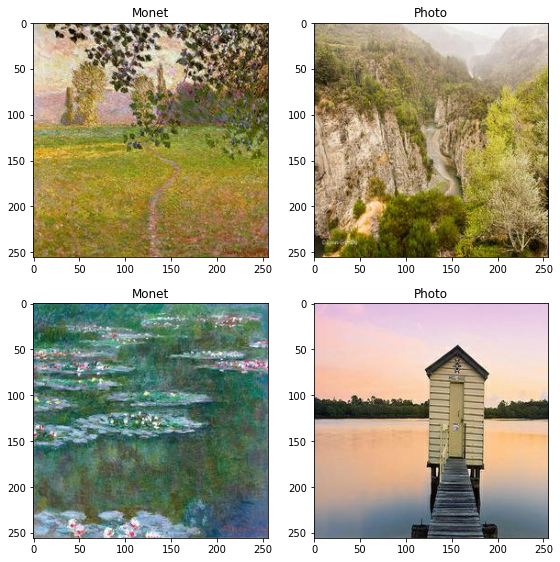

In [23]:
# visualizing samples from Monet and photo datasets
fig, ax = plt.subplots(2, 2, figsize=(8, 8))
fig.tight_layout(pad=1.5)
for i in range(2):
    image = cv2.imread(os.path.join(MONET_JPG_PATH, random.choice(monet_imgs)))
    image2 = cv2.imread(os.path.join(PHOTO_JPG_PATH, random.choice(photo_imgs)))
    ax[i,0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    ax[i,0].set_title('Monet')
    ax[i,1].imshow(cv2.cvtColor(image2, cv2.COLOR_BGR2RGB))
    ax[i,1].set_title('Photo')

We will also create histograms to display how frequently various color values occur in an image. Thus, we can compare histograms for Monet paintings and real photos.

In [24]:
def plot_histogram(image, name):
    plt.figure(figsize=(40,10))
    plt.subplot(1,3,1)

    plt.axis('off')
    plt.title(name, fontsize=30)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
 
    blue_histogram = cv2.calcHist([image], [0], None, [256], [0, 256])
    red_histogram = cv2.calcHist([image], [1], None, [256], [0, 256])
    green_histogram = cv2.calcHist([image], [2], None, [256], [0, 256]) 
 
    plt.subplot(1,3,2)
    plt.title('Histogram of All Colors', fontsize=30)
    plt.hist(blue_histogram, color='darkblue')
    plt.hist(green_histogram, color='green')
    plt.hist(red_histogram, color='red')
 
    plt.subplot(1,3,3)
    plt.title('Line Plots of All Colors', fontsize=30)
    plt.plot(blue_histogram, color='darkblue')
    plt.plot(green_histogram, color='green')
    plt.plot(red_histogram, color='red')
 
    plt.tight_layout()
    plt.show()

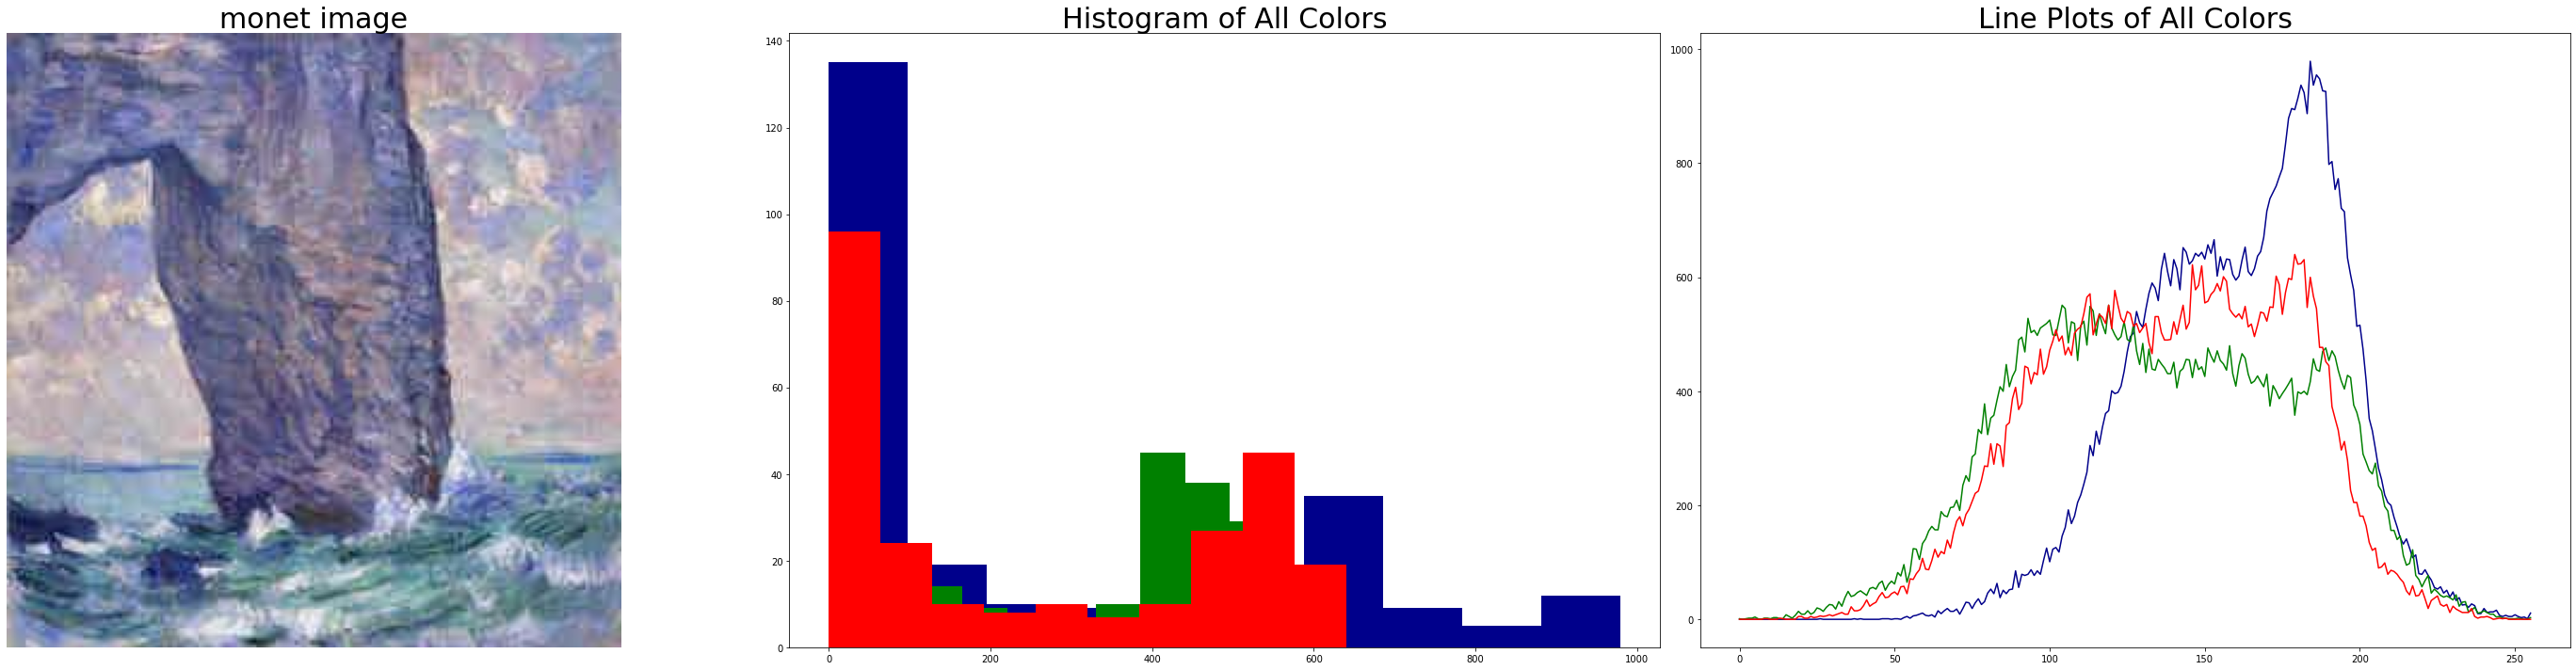

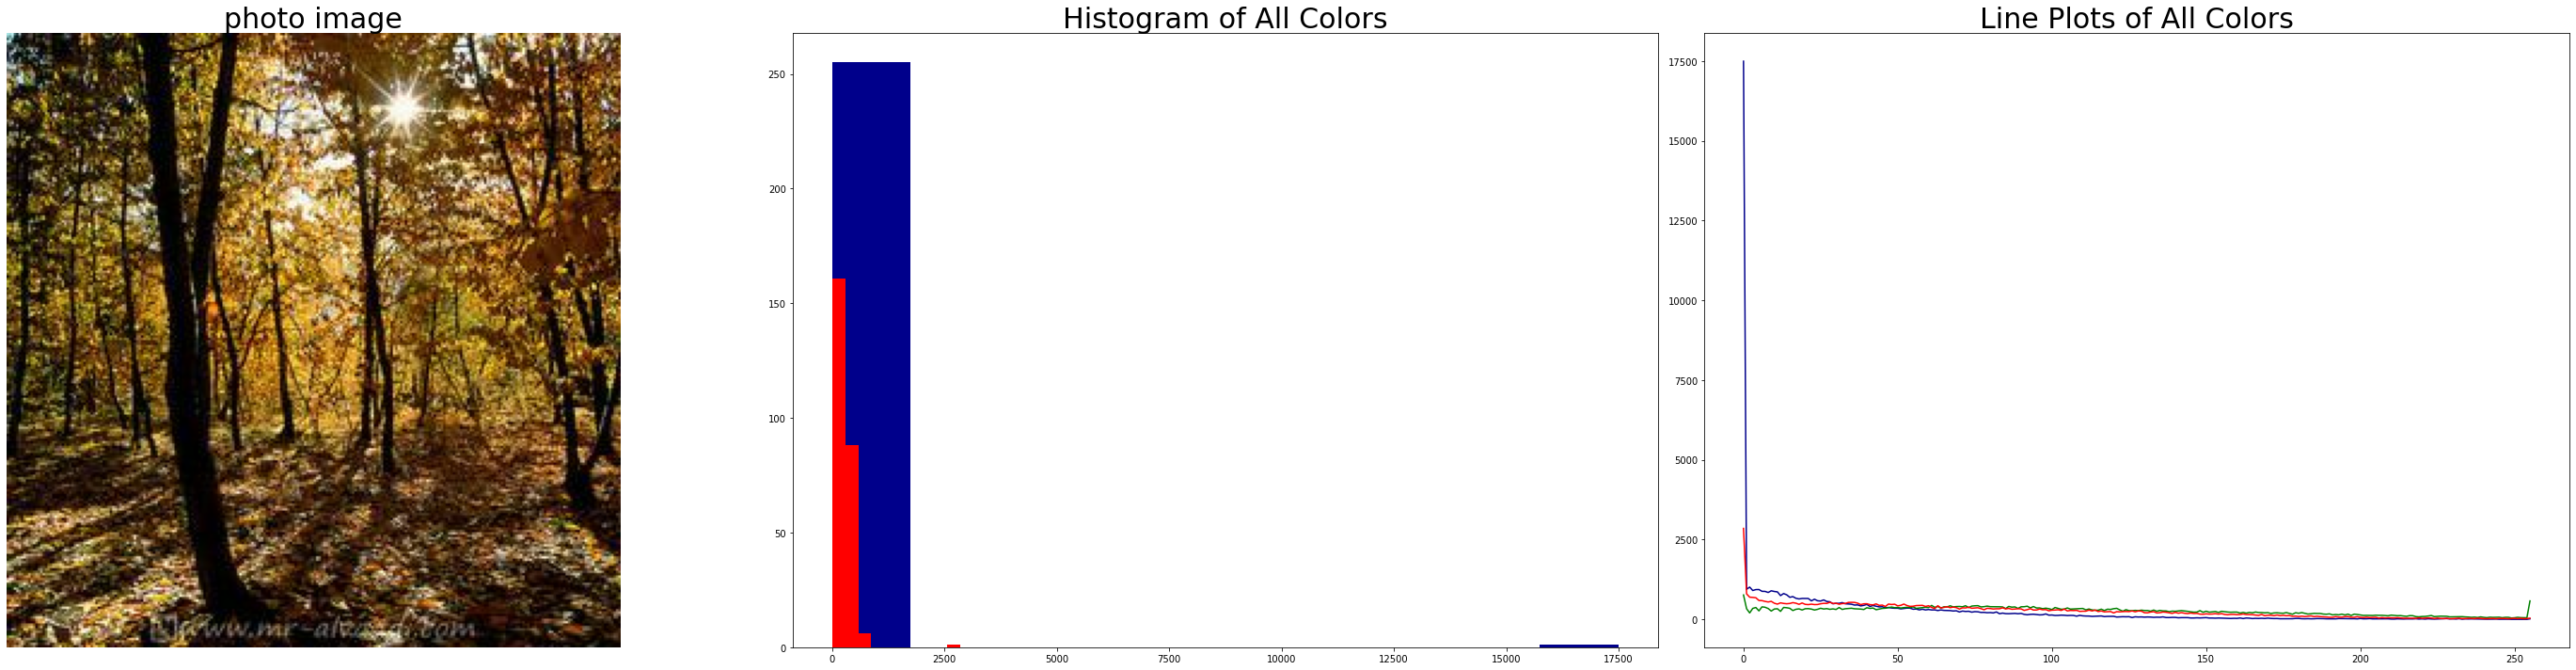

In [25]:
image = cv2.imread(os.path.join(MONET_JPG_PATH, random.choice(monet_imgs)))
plot_histogram(image, name="monet image")
image2 = cv2.imread(os.path.join(PHOTO_JPG_PATH, random.choice(photo_imgs)))
plot_histogram(image2, name="photo image")


# 3. Model creation

For this project the Cycle Generative Adversarial Network (or CycleGAN) was used. It doesn't require paired training datasets, which is perfect in this case. It means that we can give any images to CycleGAN as references, and Monet artworks as style goals and the model will learn the translation.

Generally, GANs consist from two essential parts:
1. Generator which creates fake data i.e (images).
2. Discriminator differenciates fake and real images

Generator and discriminator compete with each other: generator tries to maximize the probability of making the discriminator to incorrectly classify its inputs as real, while discriminator learns to discriminate real images from fake ones.

Our CycleGAN model architecture is comprised of two generator models: one generator (monet_generator) for generating Monet-esque images from photos and the second generator (photo_generator) for generating photographic images from Monet paintings. 
Each generator has a corresponding discriminator model. The first discriminator model (monet_discriminator) takes real Monet images and generated images from monet_generator and predicts whether they are real or fake. The second discriminator model (photo_discriminator) takes real photo images and generated images from photo_generator and predicts whether they are real or fake.


## Generator

The generator is an encoder-decoder model architecture. The model takes a source image (e.g. photo) and generates a target image (e.g. Monet painting). Our generator model consists of 3 main blocks: 
1. downsampling (encodes the input image, reducing the 2D dimensions);
2. ResNet layers that use skip connections to help bypass vanishing gradient problem;
3. upsampling layers that decode the representation to the size of the output image.

We will also use Instance Normalization instead of Batch Normalization.

In [27]:
image_shape = [256,256,3]

In [48]:
def downsample(filters, size=3, strides=2):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    block = keras.Sequential()
    # Convolution
    block.add(layers.Conv2D(filters, size, strides, padding='same', kernel_initializer=initializer, use_bias=False))

    # Normalization
    block.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))

    # Activation
    block.add(layers.LeakyReLU())

    return block


In [43]:
def upsample(filters, size=3, strides=2):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    block = keras.Sequential()
    # Transposed convolutional layer
    block.add(layers.Conv2DTranspose(filters, size, strides, padding='same',
                                     kernel_initializer=initializer, use_bias=False))

    # Normalization
    block.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))

    # Activation
    block.add(layers.ReLU())
    return block

In [44]:
def resnet_block(input_layer, size=3, strides=1):
    initialization = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
    filters = input_layer.shape[-1]
    resnet = layers.Conv2D(filters, size, strides, padding='same', kernel_initializer=initialization)(input_layer)
    resnet = tfa.layers.InstanceNormalization(gamma_initializer=gamma_init)(resnet)
    resnet = layers.ReLU()(resnet)
   
    resnet = layers.Conv2D(filters, size, strides, padding='same', kernel_initializer=initialization)(resnet)
    resnet = tfa.layers.InstanceNormalization(gamma_initializer=gamma_init)(resnet)
   
    resnet = layers.Add()([resnet, input_layer])
    return resnet

In [45]:
def generator():
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
    inputs = layers.Input(shape=image_shape)
    g = inputs

    down_layers = [downsample(64, 7, 1),
                   downsample(128, 3, 2),
                   downsample(256, 3, 2)]

    skips = []
    for layer in down_layers:
        g = layer(g)
        skips.append(g)

    skips = reversed(skips[:-1])

    for n in range(9):
        g = resnet_block(g, 3, 1)

    up_layers = [upsample(256, 3, 2),
                 upsample(128, 3, 2),
                 upsample(64, 3, 2), ]

    for layer, skip in zip(up_layers, skips):
        g = layer(g)
        g = layers.Concatenate()([g, skip])

    output_layer = layers.Conv2D(3, 7, strides=1, padding='same', kernel_initializer=initializer,
                                 activation='tanh')(g)


    return keras.Model(inputs=inputs, outputs=output_layer)

## Discriminator

In [51]:
def discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    # source image input
    in_image = layers.Input(shape=image_shape)
    d = in_image
    
    #down64
    d = downsample(64, 4, 2)(d)
    #down128
    d = downsample(128, 4, 2)(d) 
    #down256
    d = downsample(256, 4, 2)(d)
    
    #second last output layer
    d = layers.Conv2D(512, 4, padding='same', kernel_initializer=initializer)(d)
    d = layers.LeakyReLU(alpha=0.2)(d)
    
    #patch output
    patch_out = layers.Conv2D(1, 4, padding='same', kernel_initializer=initializer)(d)
    
    # define model
    model = Model(in_image, patch_out)
    
    # compile model
    model.compile(loss='mse', optimizer=Adam(learning_rate=0.0002, beta_1=0.5), loss_weights=[0.5])
    
    return model

In [54]:
with strategy.scope():
    # transforms photos to Monet-esque paintings
    monet_generator = generator()
    # transforms Monet paintings to more photographic images
    photo_generator = generator() 

    # differentiates real Monet paintings and generated Monet paintings
    monet_discriminator = discriminator() 
    # differentiates real photos and generated photos
    photo_discriminator = discriminator() 

We can test our generator now, however, we can see that it doesn't give us desirable result because the model is not trained yet

In [ ]:
example_monet = next(iter(monet_ds))
example_photo = next(iter(photo_ds))

to_monet = monet_generator(example_photo)

plt.subplot(1, 2, 1)
plt.title("Original Photo")
plt.imshow(example_photo[0] * 0.5 + 0.5)

plt.subplot(1, 2, 2)
plt.title("Monet-esque Photo")
plt.imshow(to_monet[0] * 0.5 + 0.5)
plt.show()

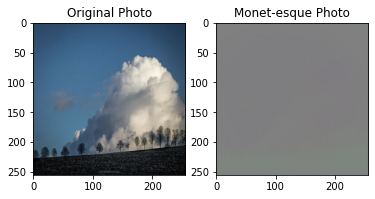

## CycleGAN model

In [57]:
class CycleGan(keras.Model):
    def __init__(
        self,
        monet_generator,
        photo_generator,
        monet_discriminator,
        photo_discriminator,
        lambda_cycle=10,
    ):
        super(CycleGan, self).__init__()
        self.monet_gen = monet_generator
        self.photo_gen = photo_generator
        self.monet_disc = monet_discriminator
        self.photo_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle
        
    def compile(
        self,
        monet_gen_optimizer,
        photo_gen_optimizer,
        monet_disc_optimizer,
        photo_disc_optimizer,
        gen_loss_fn,
        disc_loss_fn,
        cycle_loss_fn,
        identity_loss_fn
    ):
        super(CycleGan, self).compile()
        self.monet_gen_optimizer = monet_gen_optimizer
        self.photo_gen_optimizer = photo_gen_optimizer
        self.monet_disc_optimizer = monet_disc_optimizer
        self.photo_disc_optimizer = photo_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn
        
    def train_step(self, batch_data):
        real_monet, real_photo = batch_data
        
        with tf.GradientTape(persistent=True) as tape:
            # photo to monet back to photo
            fake_monet = self.monet_gen(real_photo, training=True)
            cycled_photo = self.photo_gen(fake_monet, training=True)

            # monet to photo back to monet
            fake_photo = self.photo_gen(real_monet, training=True)
            cycled_monet = self.monet_gen(fake_photo, training=True)

            # generating itself
            same_monet = self.monet_gen(real_monet, training=True)
            same_photo = self.photo_gen(real_photo, training=True)

            # discriminator used to check, inputing real images
            disc_real_monet = self.monet_disc(real_monet, training=True)
            disc_real_photo = self.photo_disc(real_photo, training=True)

            # discriminator used to check, inputing fake images
            disc_fake_monet = self.monet_disc(fake_monet, training=True)
            disc_fake_photo = self.photo_disc(fake_photo, training=True)

            # evaluates generator loss
            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)

            # evaluates total cycle consistency loss
            total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)

            # evaluates total generator loss
            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)

            # evaluates discriminator loss
            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)

        # Calculate the gradients for generator and discriminator
        monet_generator_gradients = tape.gradient(total_monet_gen_loss,
                                                  self.monet_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss,
                                                  self.photo_gen.trainable_variables)

        monet_discriminator_gradients = tape.gradient(monet_disc_loss,
                                                      self.monet_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss,
                                                      self.photo_disc.trainable_variables)

        # Apply the gradients to the optimizer
        self.monet_gen_optimizer.apply_gradients(zip(monet_generator_gradients,
                                                 self.monet_gen.trainable_variables))

        self.photo_gen_optimizer.apply_gradients(zip(photo_generator_gradients,
                                                 self.photo_gen.trainable_variables))

        self.monet_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients,
                                                  self.monet_disc.trainable_variables))

        self.photo_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients,
                                                  self.photo_disc.trainable_variables))
        
        return {
            "monet_gen_loss": total_monet_gen_loss,
            "photo_gen_loss": total_photo_gen_loss,
            "monet_disc_loss": monet_disc_loss,
            "photo_disc_loss": photo_disc_loss
        }

### Loss functions

In [58]:
# The discriminator loss outputs the average of the real and generated loss.
with strategy.scope():
    def discriminator_loss(real, generated):
        real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(real), real)

        generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.zeros_like(generated), generated)

        total_disc_loss = real_loss + generated_loss

        return total_disc_loss * 0.5

In [59]:
# Compares the generated image to a matrix of 1s to find the loss.
with strategy.scope():
    def generator_loss(generated):
        return tf.keras.losses.BinaryCrossentropy(from_logits=True, 
                                                  reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(generated), generated)

In [60]:
#A cycle consistency loss function is introduced to the optimization problem that means if we convert a 
#Monet image to a photo image and then back to a Monet image, we should get the very same input image back.
with strategy.scope():
    def calc_cycle_loss(real_image, cycled_image, LAMBDA):
        loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

        return LAMBDA * loss1

In [61]:
# The identity loss compares the input with the output of the generator.
with strategy.scope():
    def identity_loss(real_image, same_image, LAMBDA):
        loss = tf.reduce_mean(tf.abs(real_image - same_image))
        return LAMBDA * 0.5 * loss

## Train model

In [62]:
with strategy.scope():
    monet_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

    monet_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [63]:
with strategy.scope():
    cycle_gan_model = CycleGan(
        monet_generator, photo_generator, monet_discriminator, photo_discriminator
    )

    cycle_gan_model.compile(
        monet_gen_optimizer = monet_generator_optimizer,
        photo_gen_optimizer = photo_generator_optimizer,
        monet_disc_optimizer = monet_discriminator_optimizer,
        photo_disc_optimizer = photo_discriminator_optimizer,
        gen_loss_fn = generator_loss,
        disc_loss_fn = discriminator_loss,
        cycle_loss_fn = calc_cycle_loss,
        identity_loss_fn = identity_loss)

In [ ]:
cycle_gan_model.fit(
    tf.data.Dataset.zip((monet_ds, photo_ds)),
    epochs=25
)

Epoch 1/25
300/300 [==============================] - 308s 463ms/step - monet_gen_loss: 7.6805 - photo_gen_loss: 7.9966 - monet_disc_loss: 0.6783 - photo_disc_loss: 0.6681

2022-12-13 17:47:30.180255: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 18398, Output num: 3
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1670953650.176792830","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 18398, Output num: 3","grpc_status":3}

Epoch 2/25
300/300 [==============================] - 139s 463ms/step - monet_gen_loss: 7.0549 - photo_gen_loss: 7.2038 - monet_disc_loss: 0.6648 - photo_disc_loss: 0.6813

Epoch 3/25
300/300 [==============================] - 139s 463ms/step - monet_gen_loss: 6.8725 - photo_gen_loss: 7.0428 - monet_disc_loss: 0.6548 - photo_disc_loss: 0.6551

Epoch 4/25
300/300 [==============================] - 139s 463ms/step - monet_gen_loss: 6.7672 - photo_gen_loss: 6.8768 - monet_disc_loss: 0.6398 - photo_disc_loss: 0.6511

Epoch 5/25
300/300 [==============================] - 139s 464ms/step - monet_gen_loss: 6.4445 - photo_gen_loss: 6.6355 - monet_disc_loss: 0.6628 - photo_disc_loss: 0.6279

Epoch 6/25
300/300 [==============================] - 139s 463ms/step - monet_gen_loss: 6.2244 - photo_gen_loss: 6.4691 - monet_disc_loss: 0.6525 - photo_disc_loss: 0.5953

Epoch 7/25
300/300 [==============================] - 139s 463ms/step - monet_gen_loss: 5.9554 - photo_gen_loss: 6.1840 - monet_disc_loss: 0.6476 - photo_disc_loss: 0.6034

Epoch 8/25
300/300 [==============================] - 139s 463ms/step - monet_gen_loss: 5.8001 - photo_gen_loss: 6.0113 - monet_disc_loss: 0.6444 - photo_disc_loss: 0.5934

Epoch 9/25
300/300 [==============================] - 139s 463ms/step - monet_gen_loss: 5.6803 - photo_gen_loss: 5.8900 - monet_disc_loss: 0.6423 - photo_disc_loss: 0.5933

Epoch 10/25
300/300 [==============================] - 139s 463ms/step - monet_gen_loss: 5.5317 - photo_gen_loss: 5.7465 - monet_disc_loss: 0.6359 - photo_disc_loss: 0.5834

Epoch 11/25
300/300 [==============================] - 139s 464ms/step - monet_gen_loss: 5.3859 - photo_gen_loss: 5.5309 - monet_disc_loss: 0.6301 - photo_disc_loss: 0.5897

Epoch 12/25
300/300 [==============================] - 139s 463ms/step - monet_gen_loss: 5.4400 - photo_gen_loss: 5.5352 - monet_disc_loss: 0.6178 - photo_disc_loss: 0.5941

Epoch 13/25
300/300 [==============================] - 139s 463ms/step - monet_gen_loss: 5.3045 - photo_gen_loss: 5.3769 - monet_disc_loss: 0.6108 - photo_disc_loss: 0.5906

Epoch 14/25
300/300 [==============================] - 139s 463ms/step - monet_gen_loss: 5.3685 - photo_gen_loss: 5.2820 - monet_disc_loss: 0.5741 - photo_disc_loss: 0.5892

Epoch 15/25
300/300 [==============================] - 139s 464ms/step - monet_gen_loss: 5.4560 - photo_gen_loss: 5.2409 - monet_disc_loss: 0.5348 - photo_disc_loss: 0.5811

Epoch 16/25
300/300 [==============================] - 139s 463ms/step - monet_gen_loss: 5.5651 - photo_gen_loss: 5.3087 - monet_disc_loss: 0.5045 - photo_disc_loss: 0.5736

Epoch 17/25
300/300 [==============================] - 139s 463ms/step - monet_gen_loss: 5.5297 - photo_gen_loss: 5.2521 - monet_disc_loss: 0.5039 - photo_disc_loss: 0.5713

Epoch 18/25
300/300 [==============================] - 139s 464ms/step - monet_gen_loss: 5.4828 - photo_gen_loss: 5.2058 - monet_disc_loss: 0.4817 - photo_disc_loss: 0.5604

Epoch 19/25
300/300 [==============================] - 139s 463ms/step - monet_gen_loss: 5.5794 - photo_gen_loss: 5.1824 - monet_disc_loss: 0.4557 - photo_disc_loss: 0.5575

Epoch 20/25
300/300 [==============================] - 139s 463ms/step - monet_gen_loss: 5.6180 - photo_gen_loss: 5.2031 - monet_disc_loss: 0.4636 - photo_disc_loss: 0.5492

Epoch 21/25
300/300 [==============================] - 139s 463ms/step - monet_gen_loss: 5.5107 - photo_gen_loss: 5.1182 - monet_disc_loss: 0.4510 - photo_disc_loss: 0.5420

Epoch 22/25
300/300 [==============================] - 139s 463ms/step - monet_gen_loss: 5.4059 - photo_gen_loss: 5.0776 - monet_disc_loss: 0.4750 - photo_disc_loss: 0.5420

Epoch 23/25
300/300 [==============================] - 139s 463ms/step - monet_gen_loss: 5.3230 - photo_gen_loss: 4.9662 - monet_disc_loss: 0.4830 - photo_disc_loss: 0.5529

Epoch 24/25
300/300 [==============================] - 139s 463ms/step - monet_gen_loss: 5.3124 - photo_gen_loss: 5.0095 - monet_disc_loss: 0.4707 - photo_disc_loss: 0.5429

Epoch 25/25
300/300 [==============================] - 139s 463ms/step - monet_gen_loss: 5.3129 - photo_gen_loss: 4.9917 - monet_disc_loss: 0.4697 - photo_disc_loss: 0.5392

# 4. Results
### Visualize results

In [ ]:
_, ax = plt.subplots(2, 5, figsize=(25, 5))
for i, img in enumerate(photo_ds.take(5)):
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[0, i].imshow(img)
    ax[1, i].imshow(prediction)
    ax[0, i].set_title("Input Photo")
    ax[1, i].set_title("Monet-esque")
    ax[0, i].axis("off")
    ax[1, i].axis("off")
plt.show()

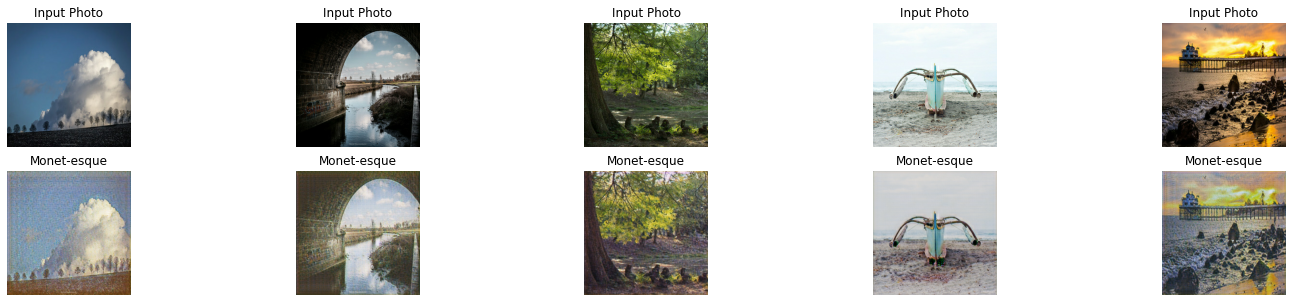

###  Export result

In [71]:

! mkdir ../images

i = 1
for img in photo_ds:
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    im = PIL.Image.fromarray(prediction)
    im.save("../images/" + str(i) + ".jpg")
    i += 1

shutil.make_archive("/kaggle/working/images", 'zip', "/kaggle/images")

'/kaggle/working/images.zip'

# 5. Conclusion

For this challenge, the CycleGAN model was implemented. It took 3 hours to ran it with TPU v3-8 acceleration. The final Kaggle score is 61.45152, which is fairly good, considering relative simplicity of our model. To improve results, different additional techniques can be used, such as hyperparameter tuning, adding other layers (dropout), data augmentation etc. 

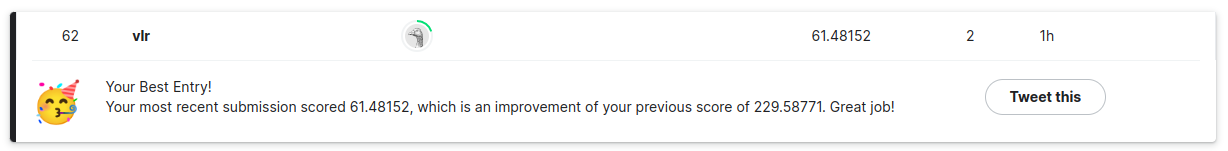

# 6. References

1. https://www.askpython.com/python/visualizing-colors-in-images
2. https://www.kaggle.com/code/amyjang/monet-cyclegan-tutorial/notebook
3. https://www.kaggle.com/code/jesperdramsch/understanding-and-improving-cyclegans-tutorial/notebook
4. https://arxiv.org/pdf/1703.10593.pdf
5. https://towardsdatascience.com/cyclegan-how-machine-learning-learns-unpaired-image-to-image-translation-3fa8d9a6aa1d
6. https://medium.com/analytics-vidhya/transforming-the-world-into-paintings-with-cyclegan-6748c0b85632
7. https://machinelearningmastery.com/cyclegan-tutorial-with-keras/